# PYGT 自定义数据集与简单建模

## 创建时序数据
共5个节点，每个节点的时序长度为200，以天为单位

In [1]:
import os
import torch
from torch_geometric.utils import dense_to_sparse
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import pandas as pd
import numpy as np
from torch_geometric_temporal.nn.recurrent import A3TGCN2
import torch.nn.functional as F
from torch_geometric_temporal.signal import temporal_signal_split

In [2]:
node_dim=5
df = pd.DataFrame(np.arange(1000).reshape(-1, 5), index=pd.date_range('2021-1-1', periods=200, freq='1D'))

In [3]:
df.head()

,0,1,2,3,4
2021-01-01,0,1,2,3,4
2021-01-02,5,6,7,8,9
2021-01-03,10,11,12,13,14
2021-01-04,15,16,17,18,19
2021-01-05,20,21,22,23,24


In [4]:
df['day'] =df.index.day # 创建特征

## 将时序数据转换为固定的格式
(T，N)--->(T,N,1),T 表示时间，N 表示节点数， 1 表示特征纬度

除了节点处的值，时序数据还会有一些其他特征，比如天、小时等XXXXX

这时，将每个特征重复 N 次，连接到 (T,N,1)，此时 (T,N,1)---->(T,N,F) F 表示特征纬度

In [5]:
def create_node(df, node_num, svpath='./', name='node_values'):
    #
    node_name = df.columns[:node_num]
    assert len(node_name) == node_num
    values = df.iloc[:, :node_num].values.reshape(-1, node_num, 1)  #  (T，N)--->(T,N,1)

    for feature in df.columns[node_num:]:  #  (T,N,1)---->(T,N,F)
        features = df[feature].repeat(node_num).values.reshape(-1, node_num, 1)
        values = np.concatenate([values, features], axis=-1)

    np.save(f"{svpath}/{name}.npy", values)

In [6]:
create_node(df,node_dim)

In [7]:
node_value = np.load('./node_values.npy')

In [8]:
node_value.shape

(200, 5, 2)

## 创建预定义邻接矩阵 A
这里直接创建了(N,N) 的全 1 矩阵。
注意，这里 A 根据情况确定是否归一化。

In [9]:
def create_adj(node_num, svpath='./', name='adj_mat'):
    """可以用两个节点之间的距离作为权重，否则均为 1"""
    adj = torch.from_numpy(np.ones((node_num, node_num)))
    #   deg_inv_sqrt = adj.sum(dim=-1).clamp(min=1).pow(-0.5)
    #   adj = deg_inv_sqrt.unsqueeze(-1) * adj * deg_inv_sqrt.unsqueeze(-2)
    np.save(os.path.join(svpath, name), adj.numpy())

In [10]:
create_adj(node_dim)

In [11]:
A = np.load('./adj_mat.npy')

In [12]:
A.shape

(5, 5)

## 创建数据集
_generate_task用来截取数据，截取过去某段时间的序列以及未来某段时间的序列，

前者作为特征，后者作为目标。若目标为单元序列，记得截取相应列。

StaticGraphTemporalSignal内置模型，用来生成数据迭代器

In [13]:
class LoadDatasetLoader(object):
    def __init__(self, raw_data_dir):
        super(LoadDatasetLoader, self).__init__()
        self.raw_data_dir = raw_data_dir
        self._read_web_data()

    def _read_web_data(self):
        A = np.load(os.path.join(self.raw_data_dir, "adj_mat.npy"))
        # (node_num,feature,sample)
        
        """注意这里数据维度的转换"""
        X = np.load(os.path.join(self.raw_data_dir, "node_values.npy")).transpose((1, 2, 0)) # (T,N,F)-->(N,F,T)
        print(X.shape)
        
        X = X.astype(np.float32)

        # Normalise as in DCRNN paper (via Z-Score Method)
        means = np.mean(X, axis=(0, 2))
        X = X - means.reshape(1, -1, 1)
        stds = np.std(X, axis=(0, 2))
        X = X / stds.reshape(1, -1, 1)

        self.A = torch.from_numpy(A)
        self.X = torch.from_numpy(X)

    def _get_edges_and_weights(self):
        edge_indices, values = dense_to_sparse(self.A)
        edge_indices = edge_indices.numpy()
        values = values.numpy()
        self.edges = edge_indices
        self.edge_weights = values

    def _generate_task(self, num_timesteps_in: int = 12, num_timesteps_out: int = 12):
        """
        (num_nodes, num_node_features, num_timesteps_in) -> (num_nodes, num_timesteps_out)

        Args:
            num_timesteps_in (int): number of timesteps the sequence model sees
            num_timesteps_out (int): number of timesteps the sequence model has to predict
        """

        indices = [
            (i, i + (num_timesteps_in + num_timesteps_out))
            for i in range(0, self.X.shape[2] - (num_timesteps_in + num_timesteps_out) + 1, 1)
        ]

        # Generate observations
        features, target = [], []
        for i, j in indices:
            features.append((self.X[:, :, i: i + num_timesteps_in]).numpy())
            target.append((self.X[:, 0, i + num_timesteps_in: j]).numpy())

        self.features = features
        self.targets = target

    def get_dataset(self, num_timesteps_in: int = 12, num_timesteps_out: int = 12) -> StaticGraphTemporalSignal:
        """Returns data iterator for Load dataset as an instance of the
        static graph temporal signal class.
        """
        self._get_edges_and_weights()
        self._generate_task(num_timesteps_in, num_timesteps_out)
        dataset = StaticGraphTemporalSignal(self.edges, self.edge_weights, self.features, self.targets)
        return dataset

In [14]:
load = LoadDatasetLoader('./')
dataset = load.get_dataset(num_timesteps_in=3, num_timesteps_out=2)


print(len(dataset.features))

(5, 2, 200)
196


## 划分训练集/测试集

In [15]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.7)

print("Number of train buckets: ", len(set(train_dataset)))
print("Number of test buckets: ", len(set(test_dataset)))

Number of train buckets:  137
Number of test buckets:  59


## 将Dataset转换为DataLoader

In [16]:
DEVICE = torch.device('cpu') # cuda
shuffle = True
batch_size=4

train_input = np.array(train_dataset.features) # (200, 5, 2, 3)
train_target = np.array(train_dataset.targets) # (200, 5, 2)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

test_input = np.array(test_dataset.features) # (, 5 ,2, 3)
test_target = np.array(test_dataset.targets) # (, 5, 2)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=False,drop_last=True)

## 构建模型

In [17]:

"""
这里选了A3TGCN2模型
"""

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, out_channel, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=64, periods=periods, batch_size=batch_size)  # node_features=2, periods=3
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(64, out_channel)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 5, 2, 3]  returns h [b, 5, 64]
        h = F.relu(h)
        h = self.linear(h)
        return h

model = TemporalGNN(node_features=len(df.columns)-node_dim+1, out_channel=2, periods=3, batch_size=batch_size)

In [18]:
print(len(train_loader))

34


## 训练与测试

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

model.train()

for epoch in range(100):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step = step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

model.eval()
step = 0
# Store for analysis
total_loss = []
true = []
fore = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    fore.append(y_hat.detach().cpu().numpy())
    true.append(labels.detach().cpu().numpy())
    # Store for analysis below
    # test_labels.append(labels)
    # predictions.append(y_hat)

print("Test MSE: {:.4f}".format(sum(total_loss) / len(total_loss)))

Epoch 0 train RMSE: 0.5159
Epoch 1 train RMSE: 0.1528
Epoch 2 train RMSE: 0.0169
Epoch 3 train RMSE: 0.0046
Epoch 4 train RMSE: 0.0032
Epoch 5 train RMSE: 0.0025
Epoch 6 train RMSE: 0.0018
Epoch 7 train RMSE: 0.0014
Epoch 8 train RMSE: 0.0010
Epoch 9 train RMSE: 0.0008
Epoch 10 train RMSE: 0.0006
Epoch 11 train RMSE: 0.0005
Epoch 12 train RMSE: 0.0004
Epoch 13 train RMSE: 0.0003
Epoch 14 train RMSE: 0.0003
Epoch 15 train RMSE: 0.0002
Epoch 16 train RMSE: 0.0003
Epoch 17 train RMSE: 0.0003
Epoch 18 train RMSE: 0.0002
Epoch 19 train RMSE: 0.0002
Epoch 20 train RMSE: 0.0002
Epoch 21 train RMSE: 0.0002
Epoch 22 train RMSE: 0.0002
Epoch 23 train RMSE: 0.0002
Epoch 24 train RMSE: 0.0002
Epoch 25 train RMSE: 0.0002
Epoch 26 train RMSE: 0.0002
Epoch 27 train RMSE: 0.0001
Epoch 28 train RMSE: 0.0001
Epoch 29 train RMSE: 0.0001
Epoch 30 train RMSE: 0.0001
Epoch 31 train RMSE: 0.0002
Epoch 32 train RMSE: 0.0001
Epoch 33 train RMSE: 0.0001
Epoch 34 train RMSE: 0.0001
Epoch 35 train RMSE: 0.0001
Ep

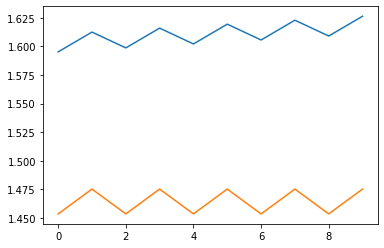

In [20]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


plt.plot(labels[0].flatten())
plt.plot((y_hat.detach().numpy())[0].flatten())
